# Mapping 'sit-lie' arrests by LAPD: 2010-19

In [36]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read in arrests data from city portal

In [2]:
# https://data.lacity.org/api/views/yru6-6re4/rows.csv?accessType=DOWNLOAD
arrests = pd.read_csv('/Users/mhustiles/data/data/LA/Arrest_Data_from_2010_to_Present.csv')

### Clean up arrests DataFrame

In [3]:
arrests.columns = arrests.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
arrests['arrest_date'] = pd.to_datetime(arrests['arrest_date'], format='%m/%d/%Y')
arrests['year'] = arrests['arrest_date'].dt.year
arrests['day'] = arrests['arrest_date'].dt.day
arrests['month'] = arrests['arrest_date'].dt.month
arrests['monthname'] = arrests['arrest_date'].dt.month_name()
arrests[['report_id', 'time', 'area_id', 'charge_group_code', 'reporting_district', 'year', 'month', 'day']] = \
arrests[['report_id', 'time', 'area_id', 'charge_group_code', 'reporting_district', 'year', 'month','day']].astype(str)
arrests['charge_group_code'] = arrests['charge_group_code'].str.replace('.0', '', regex=False)
arrests['weekday'] = arrests['arrest_date'].dt.weekday_name
arrests['time'] = arrests['time'].str.replace('.0','', regex=False)
arrests['time'] = arrests['time'].str.zfill(4)
arrests['hour'] = arrests['time'].str[:2]
arrests['minute'] = arrests['time'].str[2:]
arrests = arrests[arrests['hour'] != '0n']
arrests = arrests[arrests['hour'] != '24']

# Highlight nighttime hours
night = ['01', '02', '03', '04', '05', '22', '23', '00']
arrests['night'] = arrests['hour'].isin(night)
night_arrests = arrests[arrests['hour'].isin(night)]

# Separate location field into lat/lon
arrests['location'] = arrests.location.str.replace('(', '').str.replace(')', '')

lat = []
lon = []

for row in arrests['location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)

arrests['latitude'] = lat
arrests['longitude'] = lon
arrests['latitude'] = arrests['latitude'].astype(float)
arrests['longitude'] = arrests['longitude'].astype(float)

In [4]:
mile = gpd.read_file('input/mile.geojson')
halfmile = gpd.read_file('input/halfmile.geojson')
halfmile_mapshaper = gpd.read_file('input/halfmile-mapshaper.json')
halfmileshp = gpd.read_file('input/shp/halfmile.shp')
mile_gdf = gpd.GeoDataFrame(mile, geometry='geometry')
halfmile_gdf = gpd.GeoDataFrame(halfmile, geometry='geometry')

In [5]:
halfmile_mapshaper['geometry'] = halfmile_mapshaper['geometry'].to_crs(epsg=4326)
halfmileshp['geometry'] = halfmileshp['geometry'].to_crs(epsg=4326)
mile['geometry'] = mile['geometry'].to_crs(epsg=4326)

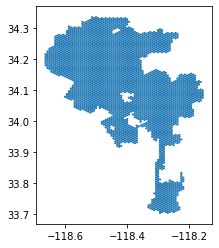

In [6]:
halfmile_mapshaper.plot()

In [58]:
halfmile_mapshaper.to_file('output/halfmile_mapshaper.json', driver='TopoJSON')

DriverError: unsupported mode: 'w'

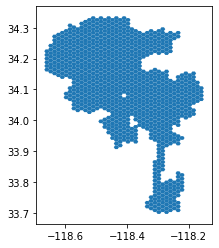

In [7]:
mile_gdf.plot()

### Isolate sit-lie cases from larger arrests dataframe

In [8]:
sit_lie_all = arrests[arrests.charge.str.contains('41.18')]

### Convert the sit-lie cases to a geodataframe

In [15]:
sit_lie_all_gdf = gpd.GeoDataFrame(sit_lie_all, \
geometry=gpd.points_from_xy(sit_lie_all.longitude, sit_lie_all.latitude))

### Remove stray LA arrests with the clip_data module

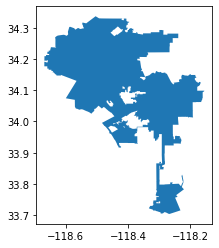

In [10]:
# Read city of Los Angeles boundary file
la = gpd.read_file('input/la_city_boundary/la_city_boundary_1570551157861.geojson')
la.plot()

In [11]:
sit_lie_all_gdf_clipped = cl.clip_shp(sit_lie_all_gdf, la)

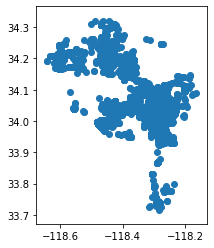

In [12]:
sit_lie_all_gdf_clipped.plot()

### Join arrests data to hexbin geodataframes

In [19]:
sit_lie_halfmile = gpd.sjoin(sit_lie_all_gdf, halfmile_mapshaper, op = 'within')

In [21]:
sit_lie_halfmile.head()

,report_id,arrest_date,time,area_id,area_name,reporting_district,age,sex_code,descent_code,charge_group_code,charge_group_description,arrest_type_code,charge,charge_description,address,cross_street,location,year,day,month,monthname,weekday,hour,minute,night,latitude,longitude,geometry,index_right,left,top,right,bottom,id
393,192116601,2019-10-02,0900,21,Topanga,2185,37,M,W,20,Disorderly Conduct,M,41.18(A)LAM,LOITER/OBSTRUCT STREET/SIDEWALK/ETC****,VENTURA BL,FARRALONE AV,"34.1687, -118.6102",2019,2,10,October,Wednesday,09,00,False,34.1687,-118.6102,POINT (-118.6102 34.1687),337,-1.320381e+07,4.052057e+06,-1.320288e+07,4.051252e+06,982
1052,192116424,2019-09-29,1000,21,Topanga,2185,37,M,W,20,Disorderly Conduct,M,41.18ALAMC,LOITER/OBSTRUCT STREET/SIDEWALK/ETC,FARRALONE,VENTURA,"34.1687, -118.6102",2019,29,9,September,Sunday,10,00,False,34.1687,-118.6102,POINT (-118.6102 34.1687),337,-1.320381e+07,4.052057e+06,-1.320288e+07,4.051252e+06,982
129549,182112679,2018-06-12,1930,21,Topanga,2177,79,M,W,nan,NaN,M,41.18(D)LAM,NaN,TOPANGA CANYON BL,BURBANK BL,"34.172, -118.6058",2018,12,6,June,Tuesday,19,30,False,34.1720,-118.6058,POINT (-118.6058 34.172),337,-1.320381e+07,4.052057e+06,-1.320288e+07,4.051252e+06,982
137836,182110517,2018-05-16,0920,21,Topanga,2175,52,M,W,20,Disorderly Conduct,M,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,TOPANGA CANYON BL,VENTURA BL,"34.171, -118.6058",2018,16,5,May,Wednesday,09,20,False,34.1710,-118.6058,POINT (-118.6058 34.171),337,-1.320381e+07,4.052057e+06,-1.320288e+07,4.051252e+06,982
138429,182110516,2018-05-14,0830,21,Topanga,2175,53,M,W,20,Disorderly Conduct,M,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,TOPANGA CANYON BL,VENTURA BL,"34.171, -118.6058",2018,14,5,May,Monday,08,30,False,34.1710,-118.6058,POINT (-118.6058 34.171),337,-1.320381e+07,4.052057e+06,-1.320288e+07,4.051252e+06,982


In [46]:
sit_lie_halfmile_grouped = sit_lie_halfmile.groupby(['year', 'id', 'area_name'])\
.agg('size').sort_values(ascending=False).reset_index(name='total')

In [47]:
sit_lie_halfmile_grouped.head()

,year,id,area_name,total
0,2017,7151,Central,1783
1,2016,7151,Central,1381
2,2013,7151,Central,1336
3,2014,7151,Central,1104
4,2015,7151,Central,1099


### Merge grouped arrests data back to binned geodataframe

In [48]:
la_bins_sit_lie = halfmile_mapshaper.merge(sit_lie_halfmile_grouped, on='id')
la_bins_sit_lie.sort_values(by='total', ascending=False).head(30)

,left,top,right,bottom,id,geometry,year,area_name,total
1559,-1.316339e+07,4.035159e+06,-1.316246e+07,4.034354e+06,7151,POLYGON ((-118.2487647575691 34.04433111175853...,2017,Central,1783
1560,-1.316339e+07,4.035159e+06,-1.316246e+07,4.034354e+06,7151,POLYGON ((-118.2487647575691 34.04433111175853...,2016,Central,1381
1561,-1.316339e+07,4.035159e+06,-1.316246e+07,4.034354e+06,7151,POLYGON ((-118.2487647575691 34.04433111175853...,2013,Central,1336
1562,-1.316339e+07,4.035159e+06,-1.316246e+07,4.034354e+06,7151,POLYGON ((-118.2487647575691 34.04433111175853...,2014,Central,1104
1563,-1.316339e+07,4.035159e+06,-1.316246e+07,4.034354e+06,7151,POLYGON ((-118.2487647575691 34.04433111175853...,2015,Central,1099
1564,-1.316339e+07,4.035159e+06,-1.316246e+07,4.034354e+06,7151,POLYGON ((-118.2487647575691 34.04433111175853...,2012,Central,963
1565,-1.316339e+07,4.035159e+06,-1.316246e+07,4.034354e+06,7151,POLYGON ((-118.2487647575691 34.04433111175853...,2018,Central,560
462,-1.316270e+07,4.034756e+06,-1.316177e+07,4.033951e+06,7258,POLYGON ((-118.2425047002445 34.04133627796971...,2014,Central,387
1612,-1.316339e+07,4.034354e+06,-1.316246e+07,4.033549e+06,7152,POLYGON ((-118.2487647575691 34.03834133842581...,2014,Central,358
463,-1.316270e+07,4.034756e+06,-1.316177e+07,4.033951e+06,7258,POLYGON ((-118.2425047002445 34.04133627796971...,2013,Central,357


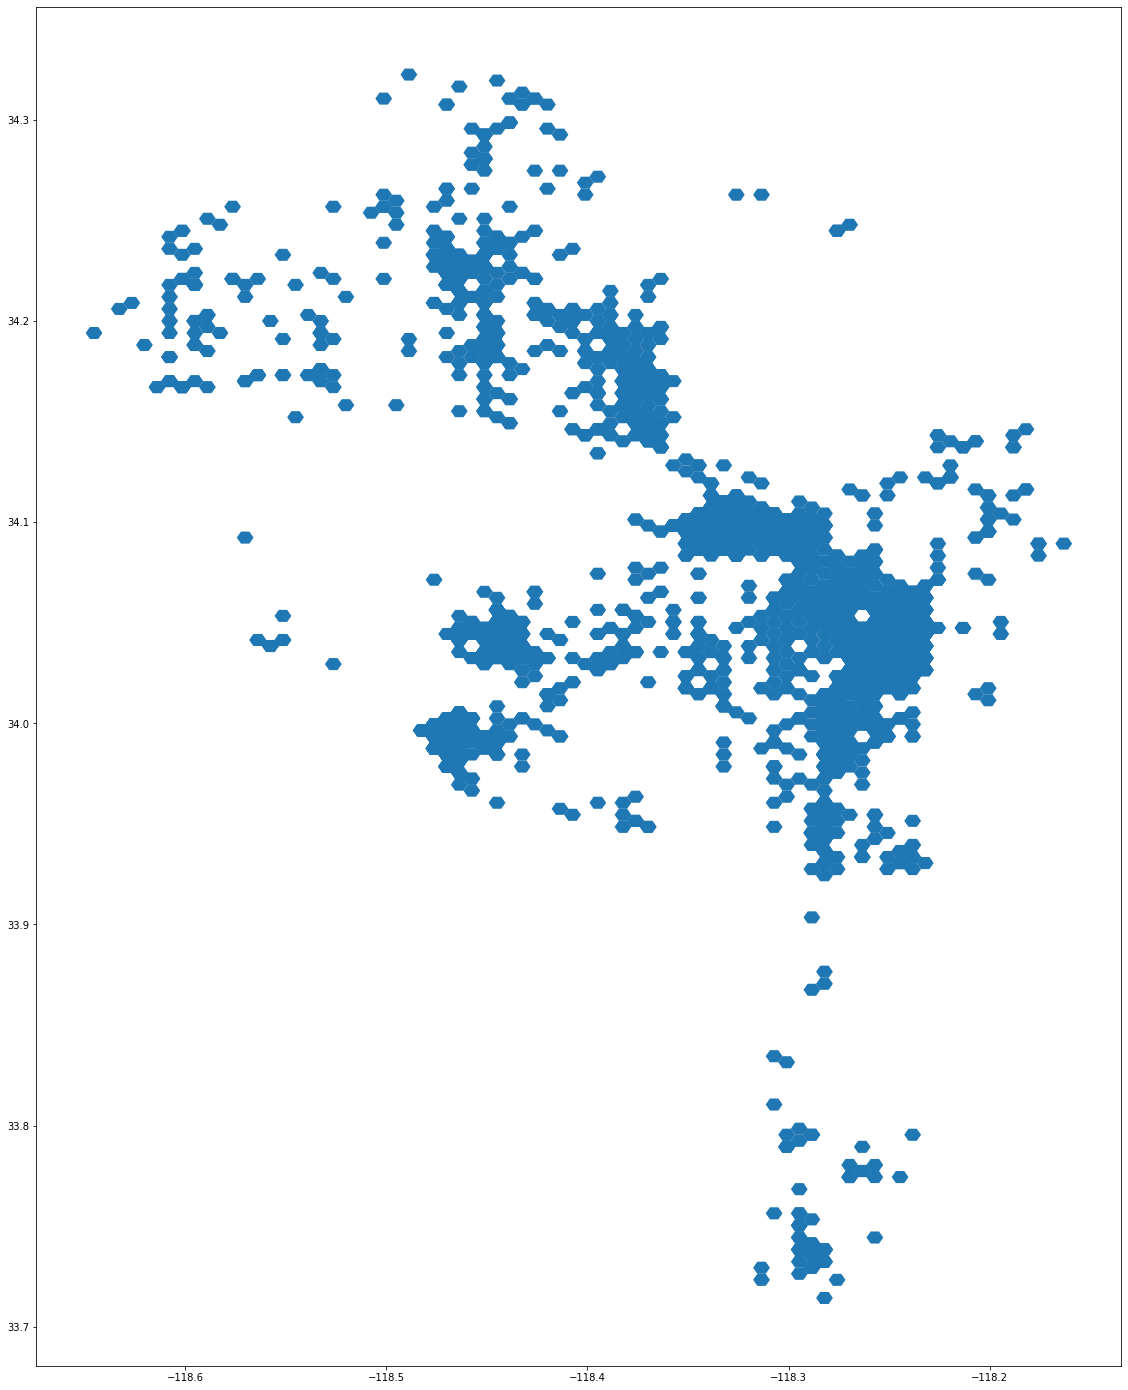

In [49]:
la_bins_sit_lie.plot()
plt.rcParams["figure.figsize"] = [20,25]

In [55]:
la_bins_sit_lie_clean = la_bins_sit_lie[['id', 'total', 'year', 'area_name', 'geometry']]
la_bins_sit_lie_csv = la_bins_sit_lie[['id', 'total', 'year']]

In [54]:
la_bins_sit_lie_clean.to_file('output/la_bins_sit_lie_clean.geojson', driver='GeoJSON')

In [56]:
la_bins_sit_lie_csv.to_csv('output/la_bins_sit_lie_csv.csv')